# Churn Predictive Model

In this code, we are developing a churn prediction model to help the company forecast whether a customer is likely to churn within the next 30 days. We utilize both order and customer datasets to build our model. The order dataset provides performance information, while the customer dataset directly indicates the retention status of the customers.

We use the same data from report-orders-utc (27) and report-customers-details (4). However, we convert the number columns in strings to numeric format to make them suitable for use and rename the datasets to 'report' and 'customer'.

## 1） Prepare the Data

In this part we first load the order data, and sort them by customer and date.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# load
data = pd.read_csv('../Downloads/Data We Used/Retention and LTV/report.csv')
df1 = pd.DataFrame(data)

# convert date
df1["Order Date (UTC)"] = pd.to_datetime(df1["Order Date (UTC)"], format="%m/%d/%y")

# sort by customer and date
df1 = df1.sort_values(["Customer ID", "Order Date (UTC)"])

# compute consecutive time difference
df1["time_diff"] = df1.groupby("Customer ID")["Order Date (UTC)"].diff()

print(df1)


          Order Number Order Status Order Date (UTC) Order Time (UTC)  \
0       HRPK-GUFN-4AKR     Refunded       2020-03-31          2:44 PM   
1       HRPK-GUFN-4AKR     Refunded       2020-03-31          2:44 PM   
2       72XV-GEH6-4AKR     Refunded       2020-03-31          2:46 PM   
3       72XV-GEH6-4AKR     Refunded       2020-03-31          2:46 PM   
4       UF5C-G9MA-4AKR     Refunded       2020-03-31          2:52 PM   
...                ...          ...              ...              ...   
212827  FAAM-G2JC-5DGG    Completed       2025-07-20          9:24 PM   
212921  NMKB-HM6Q-5DGH    Completed       2025-07-21         11:32 AM   
213027  326D-FRZW-5DGH    Completed       2025-07-21          9:10 PM   
213035  GGBG-MTBA-5DGH    Completed       2025-07-21          9:20 PM   
213465  6NNM-Y4V9-5DGJ    Completed       2025-07-23          9:21 PM   

       Order Device  Processed by System?  Customer ID         Customer Email  \
0           desktop                 False 

We want to analyze customer behavior over the last 30 days and the 30 days prior to that. The data we will collect includes their check-in times and total spending. We established two timeframes and calculated the ratio of the behavior data because we believe that a decline in activity could indicate potential churn.

In [8]:
import pandas as pd
import numpy as np

# Ensure datetime columns
df1['check_in_date'] = df1["Order Date (UTC)"]
df1['order_date'] = df1["Order Date (UTC)"]
df1['customer_id'] = df1['Customer ID']

df1 = df1.dropna(subset=['customer_id', 'order_date'])

# First/last order per customer and filter active ≥ 90 days
summary = df1.groupby('customer_id')['order_date'].agg(['min', 'max']).rename(
    columns={'min': 'first_order_date', 'max': 'last_order_date'}
)
summary['active_days'] = (summary['last_order_date'] - summary['first_order_date']).dt.days
summary = summary[summary['active_days'] >= 90]

# Join last_order_date back
dfj = df1.merge(summary[['last_order_date']], left_on='customer_id', right_index=True, how='inner')

# Define pre-windows relative to last_order_date
win1_start = dfj['last_order_date'] - pd.Timedelta(days=30)   # last month
win1_end   = dfj['last_order_date']

win2_start = dfj['last_order_date'] - pd.Timedelta(days=60)   # second last month
win2_end   = dfj['last_order_date'] - pd.Timedelta(days=30)

# Masks (use check_in_date for window assignment)
in_last_month   = (dfj['check_in_date'] >= win1_start) & (dfj['check_in_date'] <= win1_end)
in_second_month = (dfj['check_in_date'] >= win2_start) & (dfj['check_in_date'] <= win2_end)

# --- Aggregate last month (0–30 days before last order)
last_month = (
    dfj[in_last_month]
    .groupby('customer_id')
    .agg(
        last_month_checkin_days=('check_in_date', pd.Series.nunique),
        last_month_spend=('Line Total', 'sum'),
    )
)

# --- Aggregate second last month (30–60 days before last order)
second_month = (
    dfj[in_second_month]
    .groupby('customer_id')
    .agg(
        second_month_checkin_days=('check_in_date', pd.Series.nunique),
        second_month_spend=('Line Total', 'sum'),
    )
)

# Combine
out = summary.join(second_month, how='left').join(last_month, how='left').fillna(0.0)

# Ratios (handle divide-by-zero as NaN)
out['ratio_check_in'] = out['last_month_checkin_days'] / out['second_month_checkin_days'].replace(0, np.nan)
out['ratio_spend']    = out['last_month_spend']        / out['second_month_spend'].replace(0, np.nan)

# Final tidy table
cols = [
    'first_order_date','last_order_date','active_days',
    'second_month_checkin_days','last_month_checkin_days','ratio_check_in',
    'second_month_spend','last_month_spend','ratio_spend'
]
result = out[cols].reset_index()

print(result.head())


   customer_id first_order_date last_order_date  active_days  \
0      34624.0       2021-10-18      2025-06-29         1350   
1      34642.0       2023-02-27      2025-06-15          839   
2      34659.0       2022-04-25      2023-06-23          424   
3      34673.0       2020-04-07      2021-01-18          286   
4      34692.0       2022-10-24      2025-03-22          880   

   second_month_checkin_days  last_month_checkin_days  ratio_check_in  \
0                        7.0                        1        0.142857   
1                        1.0                        2        2.000000   
2                        0.0                        1             NaN   
3                        0.0                        1             NaN   
4                        0.0                        2             NaN   

   second_month_spend  last_month_spend  ratio_spend  
0               285.0             240.0     0.842105  
1                38.0              76.0     2.000000  
2          

The customer database can indicate whether a customer has churned or not. To begin, we load the data and join the two data frames together, resulting in a comprehensive dataset for model training. 

We assume that if a customer does not return within 30 days, they will be considered a churned customer. Additionally, we utilize an inner join to ensure that all customers in our training and testing datasets are active customers.

In [10]:

df = pd.read_csv("../Downloads/Data We Used/Retention and LTV/customer.csv")
df.info()
date_cols = ["Join Date","Birth Date","First Check-In","Last Check-In",
             "First Order Date","Last Order Date"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

cutoff = pd.to_datetime("2025-06-25")

df["status"] = np.where(
    df["Last Check-In"].notna() & (df["Last Check-In"] >= cutoff),
    0,
    1
)

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_38136/3157470618.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Downloads/Data We Used/Retention and LTV/customer.csv")
/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_38136/3157470618.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_38136/3157470618.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51449 entries, 0 to 51448
Data columns (total 71 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Customer ID                             51449 non-null  int64  
 1   Email                                   51449 non-null  object 
 2   First Name                              51449 non-null  object 
 3   Last Name                               51449 non-null  object 
 4   Full Name                               51449 non-null  object 
 5   Join Date                               51449 non-null  object 
 6   Created At Date                         51449 non-null  object 
 7   Updated At Date                         51449 non-null  object 
 8   Phone Number                            48924 non-null  object 
 9   Street                                  12430 non-null  object 
 10  Apt/Suite                               800 non-null    ob

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_38136/3157470618.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_38136/3157470618.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_38136/3157470618.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl4000

In [11]:
df = df[['Customer ID', 'status']]

# ---------------------------------------
# Perform INNER JOIN (different column names)
# ---------------------------------------
merged = pd.merge(
    result,
    df,
    left_on='customer_id',   # key in df_main
    right_on='Customer ID',      # key in df_status_small
    how='inner'
).drop(columns=['Customer ID'])  # remove duplicate join key

print(merged)

      customer_id first_order_date last_order_date  active_days  \
0         34624.0       2021-10-18      2025-06-29         1350   
1         34659.0       2022-04-25      2023-06-23          424   
2         34673.0       2020-04-07      2021-01-18          286   
3         34692.0       2022-10-24      2025-03-22          880   
4         34693.0       2020-04-05      2023-11-27         1331   
...           ...              ...             ...          ...   
7774      84733.0       2025-04-22      2025-07-23           92   
7775      84735.0       2025-04-22      2025-07-22           91   
7776      84757.0       2025-04-22      2025-07-21           90   
7777      84884.0       2025-04-25      2025-07-24           90   
7778      85833.0       2025-03-23      2025-07-06          105   

      second_month_checkin_days  last_month_checkin_days  ratio_check_in  \
0                           7.0                        1        0.142857   
1                           0.0            

## 2) Train the Model

We trained an XGBoost model to predict which customers are likely to churn in the next 30 days using recent behavior features (check-ins, spending, and their month-to-month changes).

Because churn is rare, we optimized the model using **PR-AUC** and applied **class weighting** to better capture churn cases. Optuna ran 50 trials to find the best hyperparameters.

We then selected a decision threshold that maximizes the **F2-score**, which emphasizes recall so we can detect more at-risk customers earlier.

Overall, the model provides an **early-warning signal** that helps the studio take action (personalized messages, offers, or recommendations) before customers fully churn.

In [14]:

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    average_precision_score,  # <-- PR-AUC (Average Precision)
    classification_report, precision_recall_curve, f1_score, roc_auc_score
)
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
import optuna
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------
# 0) Prepare X, y  (edit feature names as needed)
# --------------------------------------------
features = [
    "ratio_check_in", "ratio_spend", "second_month_checkin_days", "last_month_checkin_days", 
    "last_month_spend", "second_month_spend"
]
X = merged[features].copy()
y = merged["status"].astype(int).copy()  # 1 = churn, 0 = active

# Handle any remaining inf/NaN
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Train/test split (hold out test for final evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Class imbalance weight suggestion (neg/pos)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight_guess = max(1.0, neg / max(1, pos))

# --------------------------------------------
# 1) Define Optuna objective (maximize PR-AUC via 5-fold CV)
# --------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

def objective(trial: optuna.Trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 10),  # avoid 0-depth
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 20.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        # imbalance; also allow Optuna to nudge around the guess
        "scale_pos_weight": trial.suggest_float(
            "scale_pos_weight",
            max(1.0, 0.5*scale_pos_weight_guess),
            2.0*scale_pos_weight_guess
        ),
        "random_state": 42,
        "eval_metric": "aucpr",   # monitor PR-AUC if eval_set is provided (good practice)
        "n_jobs": -1,
        "tree_method": "hist",
    }

    pipe = Pipeline([
        ("scaler", StandardScaler()),      # (Optional for trees; harmless)
        ("xgb", XGBClassifier(**params)),
    ])

    scores = cross_val_score(
        pipe, X_train, y_train,
        scoring=pr_auc_scorer,   # <-- optimize Average Precision (PR-AUC)
        cv=cv,
        n_jobs=-1
    )
    return scores.mean()

# --------------------------------------------
# 2) Run study
# --------------------------------------------
study = optuna.create_study(direction="maximize", study_name="xgb_churn_prauc")
study.optimize(objective, n_trials=50, show_progress_bar=False)
print("Best PR-AUC (CV):", study.best_value)
print("Best params:", study.best_params)

# --------------------------------------------
# 3) Fit final model on TRAIN with best params
#    + choose threshold (maximize F2 on a small validation split)
# --------------------------------------------
best_params = {
    **study.best_params,
    "random_state": 42,
    "eval_metric": "aucpr",
    "n_jobs": -1,
    "tree_method": "hist",
}

pipe_final = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(**best_params)),
])

# Split a small validation from TRAIN to pick a decision threshold
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, stratify=y_train, random_state=123
)

pipe_final.fit(X_tr, y_tr)

val_prob = pipe_final.predict_proba(X_val)[:, 1]

# Threshold that maximizes F2 (recall-friendly)
prec, rec, thr = precision_recall_curve(y_val, val_prob)
beta = 2.0
f2 = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
best_idx = np.nanargmax(f2)
best_threshold = thr[max(0, best_idx-1)] if best_idx >= 1 else 0.5

print(f"Chosen threshold (max F2): {best_threshold:.3f}")

# --------------------------------------------
# 4) Refit on full TRAIN and evaluate on TEST
# --------------------------------------------
pipe_final.fit(X_train, y_train)

test_prob = pipe_final.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= best_threshold).astype(int)

print("\nTest PR-AUC (Average Precision):", average_precision_score(y_test, test_prob))
print("Test ROC AUC (for reference):", roc_auc_score(y_test, test_prob))
print("\nClassification report (Test, thresholded):")
print(classification_report(y_test, test_pred, digits=4))


[I 2025-12-04 17:49:23,669] A new study created in memory with name: xgb_churn_prauc
[I 2025-12-04 17:49:24,957] Trial 0 finished with value: 0.903200987902545 and parameters: {'n_estimators': 235, 'max_depth': 6, 'learning_rate': 0.004779980762792304, 'subsample': 0.7769764594535528, 'colsample_bytree': 0.6025300680903893, 'min_child_weight': 2.589028675953852, 'reg_alpha': 8.835513517380232e-07, 'reg_lambda': 2.014595384221297e-07, 'gamma': 0.9565720796330879, 'scale_pos_weight': 1.406957547209741}. Best is trial 0 with value: 0.903200987902545.
[I 2025-12-04 17:49:25,688] Trial 1 finished with value: 0.9056436637794679 and parameters: {'n_estimators': 727, 'max_depth': 4, 'learning_rate': 0.007384918781279925, 'subsample': 0.691607713217088, 'colsample_bytree': 0.9662682004632787, 'min_child_weight': 7.6647662371616985, 'reg_alpha': 0.0017325084428080585, 'reg_lambda': 1.8251715874708189e-06, 'gamma': 0.1250161357762125, 'scale_pos_weight': 1.9019663485441667}. Best is trial 1 with 

Best PR-AUC (CV): 0.9080094628934869
Best params: {'n_estimators': 670, 'max_depth': 6, 'learning_rate': 0.03576493512433637, 'subsample': 0.6554385331806143, 'colsample_bytree': 0.825306775677771, 'min_child_weight': 2.0574566970724897, 'reg_alpha': 0.0003963389576192806, 'reg_lambda': 0.0006017796836313039, 'gamma': 2.8697784821269434, 'scale_pos_weight': 1.624236036996396}
Chosen threshold (max F2): 0.500

Test PR-AUC (Average Precision): 0.9254802961371551
Test ROC AUC (for reference): 0.8048026547951898

Classification report (Test, thresholded):
              precision    recall  f1-score   support

           0     0.7882    0.1791    0.2919       374
           1     0.7913    0.9848    0.8775      1182

    accuracy                         0.7911      1556
   macro avg     0.7898    0.5820    0.5847      1556
weighted avg     0.7906    0.7911    0.7368      1556



The model can be integrated into the system, allowing you to receive a score daily. It has been trained and tested using data from customers immediately after their last visit. Therefore, I believe there is a tolerance for identifying missed churns right after their last visit, as this timing allows for accurate identification of churn within a week or ten days. We care more about the recall rate for all customers, since sending coupons to those retained customers is not necessary.

We think t = 0.85 makes our model output good since the recall of both groups is around 70%. The churned group can be 95% in 10 days, meaning that you can identify 95% churned customers in 10 days and do some actions to retain them.

In [16]:
t = 0.85
test_pred_t = (test_prob >= t).astype(int)
print(f"\nMetrics at threshold={t}:")
print(classification_report(y_test, test_pred_t, digits=4))


Metrics at threshold=0.85:
              precision    recall  f1-score   support

           0     0.4502    0.7380    0.5593       374
           1     0.8961    0.7149    0.7953      1182

    accuracy                         0.7204      1556
   macro avg     0.6732    0.7264    0.6773      1556
weighted avg     0.7889    0.7204    0.7386      1556



## 3) Confution matrix and PRC curve of the model

Confusion Matrix at threshold (0.850):
          Predicted 0  Predicted 1
Actual 0          276           98
Actual 1          337          845

Classification Report at threshold (0.850):
              precision    recall  f1-score   support

           0     0.4502    0.7380    0.5593       374
           1     0.8961    0.7149    0.7953      1182

    accuracy                         0.7204      1556
   macro avg     0.6732    0.7264    0.6773      1556
weighted avg     0.7889    0.7204    0.7386      1556



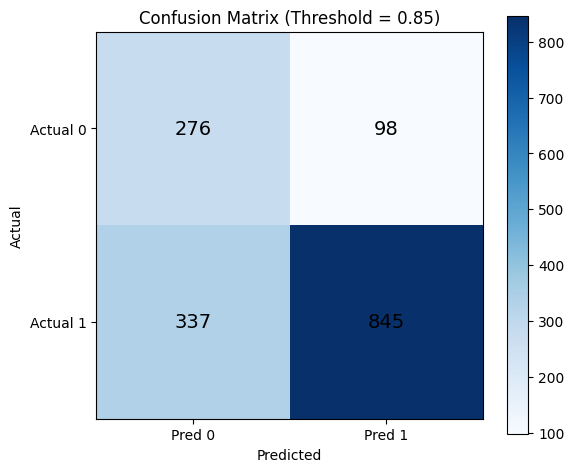

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# --------------------------------------------
# 5) Confusion matrix & classification report at chosen threshold
# --------------------------------------------
threshold_to_use = 0.85

y_pred_best = (test_prob >= threshold_to_use).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(
    cm,
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

print("Confusion Matrix at threshold ({:.3f}):".format(threshold_to_use))
print(cm_df)

print("\nClassification Report at threshold ({:.3f}):".format(threshold_to_use))
print(classification_report(y_test, y_pred_best, digits=4))

# ---------------------------
# 🔵 PLOT COLORED CONFUSION MATRIX
# ---------------------------
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')

plt.title(f"Confusion Matrix (Threshold = {threshold_to_use:.2f})")
plt.colorbar()

# Tick labels
plt.xticks([0, 1], ['Pred 0', 'Pred 1'])
plt.yticks([0, 1], ['Actual 0', 'Actual 1'])

# Add text inside squares
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=14, color='black')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


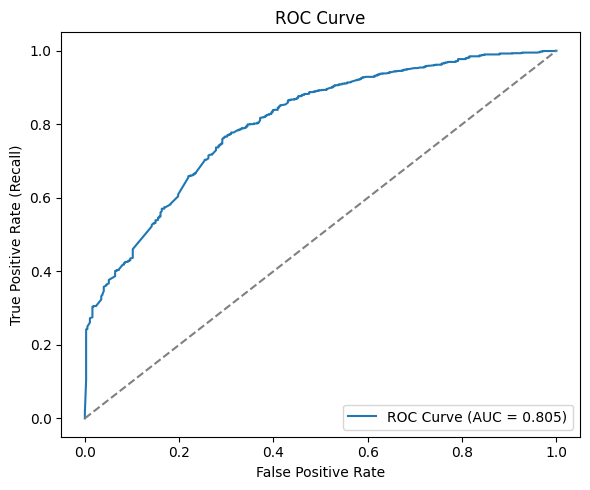

In [19]:
from sklearn.metrics import roc_curve

# Compute ROC metrics
fpr, tpr, roc_thresholds = roc_curve(y_test, test_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.3f})".format(roc_auc_score(y_test, test_prob)))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


## 4) Final Aggregating model

We used different seeds to train 5 different models and drop the best and the worst one. Then we aggregate the model to make the model more robust and stable.

In [22]:

import numpy as np
import pandas as pd
from collections import Counter, defaultdict

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import optuna
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------
# 0) Prepare X, y  (edit feature names as needed)
# ------------------------------------------------
features = [
    "ratio_check_in", "ratio_spend",
    "second_month_checkin_days", "last_month_checkin_days",
    "last_month_spend", "second_month_spend"
]
X = merged[features].replace([np.inf, -np.inf], np.nan).fillna(0).copy()
y = merged["status"].astype(int).copy()  # 1 = churn, 0 = active

# ------------------------------------------------
# Helper: inner-CV Optuna objective (PR-AUC)
# ------------------------------------------------
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

def tune_on_train(X_train, y_train, random_state=42, n_trials=40):
    # class imbalance guess for this train split
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    scale_pos_weight_guess = max(1.0, neg / max(1, pos))

    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    def objective(trial: optuna.Trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 800),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 20.0, log=True),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "scale_pos_weight": trial.suggest_float(
                "scale_pos_weight",
                max(1.0, 0.5 * scale_pos_weight_guess),
                2.0 * scale_pos_weight_guess
            ),
            "random_state": random_state,
            "n_jobs": -1,
            "tree_method": "hist",
            "eval_metric": "aucpr",
            # (binary:logistic objective by default for XGBClassifier)
        }

        pipe = Pipeline([
            ("xgb", XGBClassifier(**params)),
        ])

        scores = cross_val_score(
            pipe, X_train, y_train,
            scoring=pr_auc_scorer,
            cv=cv_inner,
            n_jobs=-1
        )
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study.best_params, study.best_value

# ------------------------------------------------
# Helper: aggregate hyperparameters across splits
#   - numeric: median
#   - integers: median then round
#   - others: most frequent
# ------------------------------------------------
def aggregate_params(param_list):
    agg = {}
    # Collect keys
    keys = set().union(*[p.keys() for p in param_list])
    for k in keys:
        vals = [p[k] for p in param_list if k in p]
        # numeric?
        if all(isinstance(v, (int, float, np.floating, np.integer)) for v in vals):
            if any(isinstance(v, float) for v in vals):
                agg[k] = float(np.median(vals))
            else:
                agg[k] = int(np.round(np.median(vals)))
        else:
            # mode / most frequent
            agg[k] = Counter(vals).most_common(1)[0][0]

    # Ensure required fixed fields
    agg["random_state"] = 42
    agg["n_jobs"] = -1
    agg["tree_method"] = "hist"
    agg["eval_metric"] = "aucpr"
    return agg

# ------------------------------------------------
# 1) Monte Carlo outer splits (5 random seeds)
# ------------------------------------------------
seeds = [11, 22, 33, 44, 55]
outer_results = []
best_params_list = []

for seed in seeds:
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=seed
    )

    # ---- inner CV tuning on train_i ----
    best_params, cv_best = tune_on_train(X_tr, y_tr, random_state=seed, n_trials=40)
    best_params_list.append(best_params)

    # ---- fit on full train_i with best params, evaluate on test_i ----
    model = XGBClassifier(**{
        **best_params,
        "random_state": seed,
        "n_jobs": -1,
        "tree_method": "hist",
        "eval_metric": "aucpr",
    })
    model.fit(X_tr, y_tr)

    test_prob = model.predict_proba(X_te)[:, 1]
    test_pr_auc = average_precision_score(y_te, test_prob)

    outer_results.append({
        "seed": seed,
        "cv_inner_best_pr_auc": cv_best,
        "test_pr_auc": test_pr_auc,
        "best_params": best_params
    })

# ------------------------------------------------
# 2) Aggregate performance over 5 splits
# ------------------------------------------------
test_scores = [r["test_pr_auc"] for r in outer_results]
mean_pr_auc = float(np.mean(test_scores))
std_pr_auc  = float(np.std(test_scores, ddof=1))

print("=== Outer Monte Carlo Results (PR-AUC) ===")
for r in outer_results:
    print(f"Seed {r['seed']}: Test PR-AUC = {r['test_pr_auc']:.4f} | "
          f"Inner-CV Best PR-AUC = {r['cv_inner_best_pr_auc']:.4f}")
print(f"\nAggregate Test PR-AUC: mean = {mean_pr_auc:.4f}, std = {std_pr_auc:.4f}")

# ------------------------------------------------
# 3) Final model for deployment: refit on FULL data
#    using aggregated hyperparameters (drop best & worst split)
# ------------------------------------------------

# sort outer results by test PR-AUC
sorted_results = sorted(outer_results, key=lambda r: r["test_pr_auc"])

# drop the worst (index 0) and best (index -1)
middle_results = sorted_results[1:-1]

print("\nUsing these seeds for aggregation (dropping best & worst):")
for r in middle_results:
    print(f"  seed {r['seed']}: test PR-AUC = {r['test_pr_auc']:.4f}")

# collect their best_params
middle_best_params_list = [r["best_params"] for r in middle_results]

# aggregate only over the middle splits
final_params = aggregate_params(middle_best_params_list)

print("\nFinal aggregated hyperparameters (after dropping best & worst):")
for k, v in final_params.items():
    print(f"  {k}: {v}")

# fit final model on FULL data
final_model = XGBClassifier(**final_params)
final_model.fit(X, y)


[I 2025-12-04 17:49:33,365] A new study created in memory with name: no-name-73dd0c17-d0be-4092-8df7-1ace60e3b292
[I 2025-12-04 17:49:33,483] Trial 0 finished with value: 0.9118205525267646 and parameters: {'n_estimators': 412, 'max_depth': 7, 'learning_rate': 0.1615170374068455, 'subsample': 0.7520639240974163, 'colsample_bytree': 0.6937825179450777, 'min_child_weight': 4.774107676986237, 'reg_alpha': 4.967883577087477e-05, 'reg_lambda': 0.8230169776989572, 'gamma': 1.4856817007809087, 'scale_pos_weight': 1.13502801432361}. Best is trial 0 with value: 0.9118205525267646.
[I 2025-12-04 17:49:33,589] Trial 1 finished with value: 0.9111377311180465 and parameters: {'n_estimators': 599, 'max_depth': 5, 'learning_rate': 0.08974247011253275, 'subsample': 0.6646680847723561, 'colsample_bytree': 0.9779925605751093, 'min_child_weight': 6.673239754477783, 'reg_alpha': 0.3674898073352842, 'reg_lambda': 1.7292653400009466e-05, 'gamma': 3.1055324582902655, 'scale_pos_weight': 1.9103430466794242}. 

=== Outer Monte Carlo Results (PR-AUC) ===
Seed 11: Test PR-AUC = 0.9158 | Inner-CV Best PR-AUC = 0.9146
Seed 22: Test PR-AUC = 0.9274 | Inner-CV Best PR-AUC = 0.9123
Seed 33: Test PR-AUC = 0.9203 | Inner-CV Best PR-AUC = 0.9130
Seed 44: Test PR-AUC = 0.9168 | Inner-CV Best PR-AUC = 0.9131
Seed 55: Test PR-AUC = 0.9128 | Inner-CV Best PR-AUC = 0.9140

Aggregate Test PR-AUC: mean = 0.9186, std = 0.0056

Using these seeds for aggregation (dropping best & worst):
  seed 11: test PR-AUC = 0.9158
  seed 44: test PR-AUC = 0.9168
  seed 33: test PR-AUC = 0.9203

Final aggregated hyperparameters (after dropping best & worst):
  colsample_bytree: 0.6924142735522072
  max_depth: 8
  learning_rate: 0.05115843523763334
  min_child_weight: 4.1289227722297905
  reg_lambda: 0.049813368890008106
  n_estimators: 512
  reg_alpha: 5.354533890814323e-08
  gamma: 1.1887142772540085
  scale_pos_weight: 1.1770783693277145
  subsample: 0.8673839303682934
  random_state: 42
  n_jobs: -1
  tree_method: hist
  e

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6924142735522072, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=1.1887142772540085, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05115843523763334,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=4.1289227722297905, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=512,
              n_jobs=-1, num_parallel_tree=None, ...)

New data needs to be used to test our best model. t = 0.85 is our preset to utilize it and I think it will make a good output, but the best t needs to be tested with new data come in.